# Regression linéaire avec les moindres carrés

In [1]:
% matplotlib inline
from numpy import zeros, zeros_like, ones, vstack, mod, loadtxt
import matplotlib.pyplot as plt
from numpy.linalg import pinv

## Introduction et notations

On reprends les notations et les algorithmes du précédent notebook.

In [2]:
def h(theta, x):
    y_estimated = 0.
    for theta_i, x_i in zip(theta, x):
        y_estimated += theta_i*x_i
    return y_estimated

In [3]:
def J(theta, X, Y):
    cost = 0.
    m = X.shape[0]
    for x_i, y_i in zip(X, Y):
        cost += (h(theta, x_i)  - y_i)**2
    return 1./(2.*m)*cost

In [4]:
def batch_update(theta, X, Y, alpha=0.01):
    new_theta = zeros_like(theta)
    m = X.shape[0]
    for j, theta_j in enumerate(theta):
        sum_derivative = 0.
        for i, (x_i, y_i) in enumerate(zip(X,Y)):
            sum_derivative += (y_i - h(theta,x_i))*x_i[j]
        new_theta[j] = theta_j + alpha*(sum_derivative)
    return new_theta

In [5]:
def stochastic_update(theta, X, Y, alpha=0.01):
    new_theta = theta.copy()
    m = X.shape[0]
    for i, (x_i, y_i) in enumerate(zip(X,Y)):
        for j, theta_j in enumerate(new_theta):
            new_theta[j] = new_theta[j] + alpha*(y_i - h(new_theta, x_i))*x_i[j]
    return new_theta

In [6]:
def normal_equation(X, Y):
    return pinv(X.T.dot(X)).dot(X.T).dot(Y)

## Application: estimation du salaire à Princeton

Pour appliquer la régression linaire, nous allons d'abord charger un ensemble de données qui contient des informations sur les salaires à l'Université de Princeton. Les données brutes sont organisées de la façon suivante :

* sx = sexe, encodé avec 1 pour les femmes et 0 pour les hommes

* rk = rang, encodé avec 1 pour *assistant professor*, 2 pour *associate professor*, et 3 pour *full professor* 

* yr = nombre d'années dans le rang courant

* dg = plus haut diplôme, 1 pour le doctorat, 0 pour le master

* yd = nombre d'années depuis que le dernier diplôme a été obtenu

* sl = salaire annuel universitaire, en US dollar 

Les données sont librement accessible sur http://data.princeton.edu/wws509/datasets/#salary

In [7]:
!wget http://data.princeton.edu/wws509/datasets/salary.raw
raw_data = loadtxt('salary.raw')
print (raw_data[0:3, :].astype(int))

/bin/sh: wget: command not found
[[    0     3    25     1    35 36350]
 [    0     3    13     1    22 35350]
 [    0     3    10     1    23 28200]]


Nous sommes pour l'instant intéressé uniquement par les années en poste et les salaires. On trie les données en fonction des années en poste et on affiche le tout.

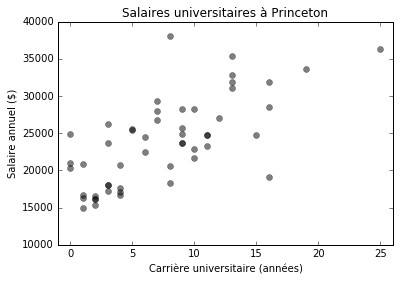

In [8]:
year_column = 2
salary_column = 5

year_min = -1; year_max = 26
salary_min = 10000; salary_max = 40000

data = raw_data[:, [year_column, salary_column]]

def plot_salaires(X, Y, color=None, label=None):
    if color is not None:
        plt.plot(X, Y, color+'o', alpha=0.5, label=label)
    else:
        plt.plot(X, Y, 'ok', alpha=0.5)
    plt.title(u'Salaires universitaires à Princeton')
    plt.xlabel(u'Carrière universitaire (années)')
    plt.ylabel(u'Salaire annuel ($)')
    plt.xlim((year_min, year_max))
    plt.ylim((salary_min, salary_max))
    if label is not None:
        plt.legend(loc='lower right')
        
def plot_regression(theta, color='b-', alpha=1):
    plt.plot([year_min, year_max], [h(theta, [1, year_min]), h(theta, [1, year_max])], 
             color, alpha=alpha)
    
plot_salaires(data[:,0], data[:,1])

On applique notre algorithme *batch* avec des iterations successives:

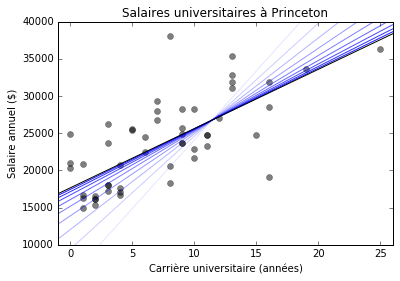

In [9]:
m = data.shape[0]
n = data.shape[1]

X = ones(shape=(m, 2))
X[:,1] = data[:,0]
Y = data[:, 1]
theta = zeros(shape=(n, 1))

plot_salaires(X[:,1], Y)

alpha = 0.0002
iteration = 1000
J_batch = zeros(iteration)
for i in range(iteration):
    theta = batch_update(theta, X, Y, alpha)
    J_batch[i] =  J(theta, X, Y)
    if (mod(i, iteration/10) == 0):
        plot_regression(theta, 'b-', alpha=float(i)/iteration)
plot_regression(theta, 'k-')

On cherche maintenant effectuer la régression linéaire avec l'algorithme stochastique

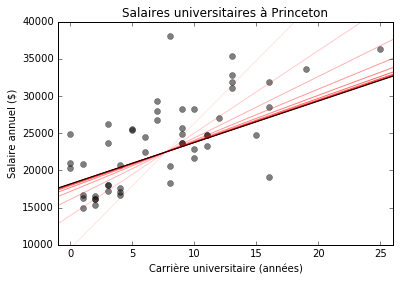

In [10]:
plot_salaires(X[:,1], Y)

theta = zeros(shape=(n, 1))
alpha = 0.001
iteration = 400
J_stochastic = zeros(iteration)
for i in range(iteration):
    theta = stochastic_update(theta, X, Y, alpha)
    J_stochastic[i] =  J(theta, X, Y)
    if (mod(i, iteration/10) == 0):        
        plot_regression(theta, 'r-', alpha=float(i)/iteration)
plot_regression(theta, 'k-')

Comparons maintenant la vitesse de convergence des algorithmes

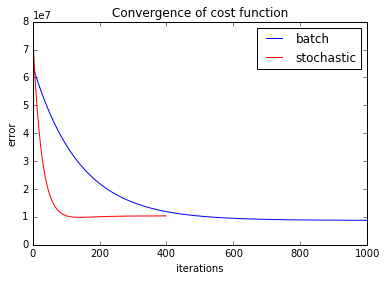

In [11]:
plt.figure()
f = plt.plot(J_batch, 'b', label='batch')
g = plt.plot(J_stochastic, 'r', label='stochastic')
plt.title('Convergence of cost function')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()

Regardons maintenant la solution obtenue avec l'équation normale:

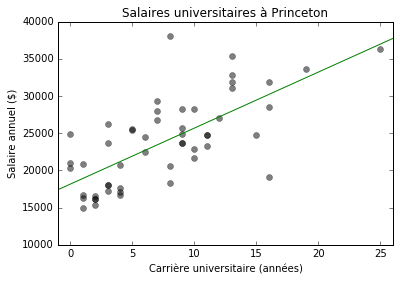

In [12]:
plot_salaires(X[:,1], Y)
theta = normal_equation(X, Y)
plot_regression(theta, 'g-')

## Discrimination salariale Femme/Homme

Nous pouvons également effectuer la regression sur les salaires des hommes et sur celui des femmes.

In [13]:
sex = 0
men = 0
women = 1

men_index = raw_data[:, sex] == men
X_men = ones(shape=(men_index.sum(), 2))
X_men[:,1] = raw_data[men_index, year_column]
Y_men = raw_data[men_index, salary_column]
theta_men = normal_equation(X_men, Y_men)

women_index = raw_data[:, sex] == women
X_women = ones(shape=(women_index.sum(), 2))
X_women[:,1] = raw_data[women_index, year_column]
Y_women = raw_data[women_index, salary_column]
theta_women = normal_equation(X_women, Y_women)

Comparons le résultat:

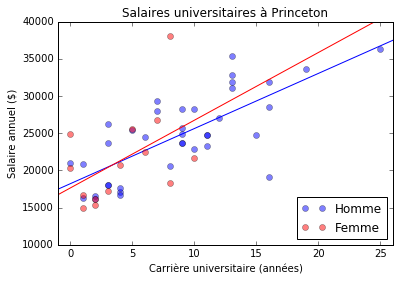

In [14]:
plot_salaires(X_men[:, 1], Y_men, color='b', label='Homme')
plot_regression(theta_men, 'b-')
plot_salaires(X_women[:, 1], Y_women, color='r', label='Femme')
plot_regression(theta_women, 'r-')

On peut voir que la progression de salaire moyen en fonction du sexe est plus avantageux pour les femmes. Attention, cette conclusion est très spécifique :

* Il y a beaucoup moins de femmes que d'hommes dans les données
* Une femme a un salaire atypique et a une influence importante car il y a peu de données
* Cette analyse utilise uniquement les années de carrière et ne tient pas compte du niveau d'étude